In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '7'

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import numpy as np
# import wandb

from transformers import BertModel, BertTokenizer
from transformers.models.bert.modeling_bert import BertEmbeddings
#from peft import get_peft_model, PrefixTuningConfig

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

In [2]:
# our negatives are going to be arbitrary passages mined from wikipedia

class TextChunkDataset(Dataset):
    def __init__(self, data, chunk_size=128, limit=1000):
        """
        Initializes the dataset.
        Args:
            data (list): List of dictionaries with text data.
            chunk_size (int): Length of each text chunk.
        """
        self.chunks = []
        self.chunk_size = chunk_size

        for i, entry in enumerate(tqdm(data)):
            text = entry['text']
            chunks = [f"{p.strip()}." for p in re.split(r'\.\s', text) if len(p) >= 30 and len(p) < 400]
            self.chunks.extend(chunks)
            # self.chunks.extend(
            #     [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
            # )
            if i >= limit:
                break

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        return self.chunks[idx]


def get_dist_loss(target_embd):
    def dist_loss(doc_embd):
        return -(doc_embd @ target_embd.T).mean()
    return dist_loss

In [3]:
ds = load_dataset("wikimedia/wikipedia", "20231101.en")['train']

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

In [4]:
ds_chunk = TextChunkDataset(ds, limit=100)
ds_chunk[7]

  0%|          | 100/6407814 [00:00<1:03:54, 1671.28it/s]


'Various anarchist schools of thought formed during this period.'

In [5]:
bert = BertModel.from_pretrained('google-bert/bert-base-uncased').to(DEVICE)
bert_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
base_embeddings = bert.embeddings

In [6]:
DATA_FILE = '../data-output/embeddings.pt'

In [7]:
def get_document_embeddings(docs_str):
    embds = []
    for doc in docs_str:
        tok = bert_tokenizer(doc, return_tensors='pt').to(DEVICE)
        with torch.inference_mode():
            out = bert(**tok)
        embds.append(out['last_hidden_state'][:, 0])
    return torch.cat(embds, dim=0)

In [8]:
bert_tokenizer.decode(bert_tokenizer('THIS IS A TEST')['input_ids'])

'[CLS] this is a test [SEP]'

In [9]:
negative_documents = [ds_chunk[i] for i in range(11)]

C:\Users\test\AppData\Local\Temp\ipykernel_5168\701289365.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(DATA_FILE)


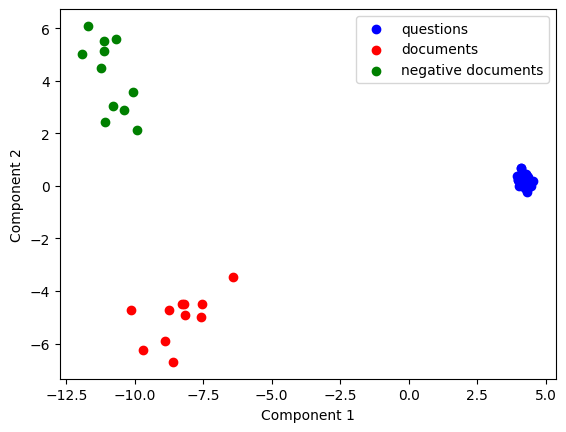

In [10]:
data = torch.load(DATA_FILE)

questions = data['questions']
embds_q = data['question_embeddings'].to(DEVICE)

documents = data['documents']
embds_d = get_document_embeddings(documents)
embds_n = get_document_embeddings(negative_documents)
# embds_d = data['document_embeddings'].to(DEVICE)

all_embds = torch.cat((embds_q, embds_d, embds_n), dim=0)

n_q = embds_q.shape[0]
n_d = embds_d.shape[0]

# projector = PCA(n_components=2)
projector = PCA(n_components=2)
projections = projector.fit_transform(all_embds.cpu().numpy())

projections_q = projections[:n_q]
projections_d = projections[n_q:n_q+n_d]
projections_n = projections[n_q+n_d:]

plt.scatter(*zip(*projections_q), color='blue', label='questions')
plt.scatter(*zip(*projections_d), color='red', label='documents')
plt.scatter(*zip(*projections_n), color='green', label='negative documents')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.legend()
plt.show()

In [11]:
embds_q.shape

torch.Size([50, 768])

In [12]:
sims_actual = embds_q[0] @ embds_d.T
sims_negative = embds_q[0] @ embds_n.T

print(sims_actual)
print(sims_negative)

tensor([37.3577, 31.6574, 28.3042, 30.9943, 32.4543, 36.0432, 39.0848, 29.7009,
        28.3630, 30.8512, 24.6314])
tensor([17.0465, 15.6502, 20.2291, 22.8085, 21.1393, 14.3226, 19.7452, 23.2663,
        13.0310, 18.9900, 22.8006])


In [13]:
print(questions[0])
print('*'*50)
print(documents)
print('*'*50)
print(negative_documents)

What are the main topics covered in CSE 227: Graduate Computer Security?
**************************************************
['Lectures: Tuesday/Thursday 11:00am-12:20pm PODEM 1A20', 'Instructor: Earlence Fernandes, Office hours: Tue 2pm to 3pm, CSE 3244', 'TA: Nishit Pandya, Office Hours: Wed 4pm to 5pm, CSE B240A.', 'Class Resources: Submissions on HotCRP; Lecture schedule, readings, and course policies on this web page', 'Grading: 80%: Course Research Project; 10%: In-person Quiz; 10%: Final Project Presentation', 'Course Overview: This course is on graduate-level computer security, focusing on the software systems foundations of building secure computer systems. We will read a mix of classic and new papers in the field and will cover a range of topics from trusted computing, operating systems, web/cloud systems, and machine learning. Our goal is to illustrate research challenges and solutions. It is not designed to be a tutorial course, but rather to give students the context to und

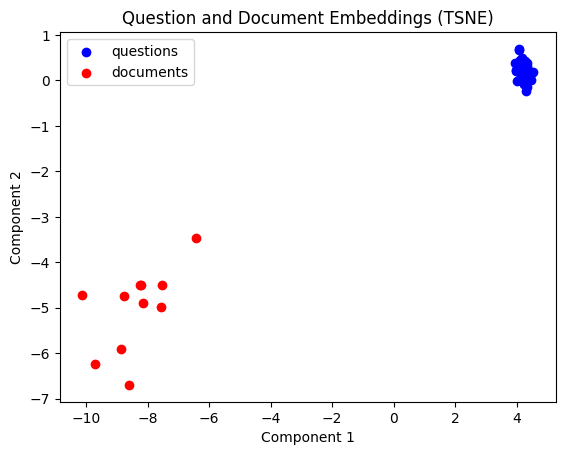

In [14]:
plt.scatter(*zip(*projections_q), color='blue', label='questions')
plt.scatter(*zip(*projections_d), color='red', label='documents')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.title("Question and Document Embeddings (TSNE)")

plt.legend()
plt.show()

In [15]:
# NEXT STEP: prefix tuning in order to minimize the distance to the average question embedding
# goal is just to steer the embedding towards the centroid of the questions, using only some prefix tokens.

In [16]:
avg_q_embd = embds_q.mean(dim=0)

In [17]:
dist_loss = get_dist_loss(avg_q_embd)

In [18]:
ex_embd = embds_q[0]

In [19]:
dist_loss(ex_embd)

C:\Users\test\AppData\Local\Temp\ipykernel_5168\1966739039.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  return -(doc_embd @ target_embd.T).mean()


tensor(-64.9581)

## Prefix Tuning

In [34]:
class PrefixEmbeddings(nn.Module):
    def __init__(self, base_embeddings, num_tokens=8, valid_index=999):
        super().__init__()
        self.valid_index = valid_index
        self.base_embeddings = base_embeddings
        self.vocab_size, self.hidden_size = self.base_embeddings.word_embeddings.weight.shape
        self.vocab_size -= self.valid_index
        
        self.num_tokens = num_tokens
        self.one_hot = nn.Embedding(num_tokens, self.vocab_size).to(DEVICE)
        with torch.no_grad():
            self.one_hot.weight.fill_(.5)

    def forward(self, input_ids, **kwargs):
        input_embds = self.base_embeddings.word_embeddings(input_ids)
        # now for some slicing and dicing
        cls_embds = input_embds[:, :1, :]
        token_embds = input_embds[:, 1:, :]
        bsz = cls_embds.shape[0]

        one_hot = nn.functional.normalize(torch.clamp(self.one_hot.weight, 0., 1.), p=1, dim=-1)
        extra_token_embeds = one_hot @ self.base_embeddings.word_embeddings.weight[self.valid_index:]

        extra_tokens = extra_token_embeds.unsqueeze(0).expand(bsz, *extra_token_embeds.shape)
        
        sandwiched_input_embeds = torch.cat((cls_embds, extra_tokens, token_embds), dim=1).float()
        token_type_ids = torch.zeros(sandwiched_input_embeds.shape[0],
                                     sandwiched_input_embeds.shape[1]).int().to(DEVICE)
            
        out = self.base_embeddings(inputs_embeds=sandwiched_input_embeds,
                                    token_type_ids=token_type_ids,
                                   past_key_values_length=0)

        return out


## Model preparation

Freeze all parameters except for the prefix embeddings.

In [35]:
## params

num_epochs = 1
lr = 1e-2
batch_size = 16
num_prefix_tokens = 32
report_freq = 100

In [36]:
def freeze_parameters(model):
    for name, param in model.named_parameters():
        param.requires_grad = False

def count_parameters(model):
    trainable = 0
    total = 0
    for name, param in model.named_parameters():
        total += param.numel()
        if param.requires_grad:
            trainable += param.numel()
    print(f"Trainable: {trainable} | Total: {total} | Percentage: {(100*trainable / total):.3f}%")

In [37]:
bert_trainable = BertModel.from_pretrained('google-bert/bert-base-uncased').to(DEVICE)
freeze_parameters(bert_trainable)
custom_embeddings = PrefixEmbeddings(bert_trainable.embeddings, num_tokens=num_prefix_tokens)

print('Base model:')
count_parameters(bert_trainable)
print('*'*50)
print('Embeddings:')
count_parameters(custom_embeddings)

Base model:
Trainable: 0 | Total: 109482240 | Percentage: 0.000%
**************************************************
Embeddings:
Trainable: 944736 | Total: 24781920 | Percentage: 3.812%


## Training loop

In [38]:
def get_one_hot(custom_embeddings):
    one_hot = custom_embeddings.one_hot.weight.detach().clone()
    return nn.functional.normalize(torch.clamp(one_hot, 0., 1.), p=1, dim=-1)

In [39]:
orig_one_hot_weight = get_one_hot(custom_embeddings)

In [40]:
torch.manual_seed(42)
ds_train, ds_val, ds_test = torch.utils.data.random_split(ds_chunk, lengths=[0.85, 0.1, 0.05])

train_dl = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

model = bert_trainable

optimizer = torch.optim.Adam(custom_embeddings.parameters(), lr=lr)

def prepare_embd_inputs(inputs, custom_embeddings):
    batch_size = len(inputs)
    tokenized_inputs = bert_tokenizer(inputs, padding=True, return_tensors='pt').to(DEVICE)
    # prepend attention_mask the same number of tokens
    tokenized_inputs['attention_mask'] = torch.cat(
        (torch.ones(batch_size, num_prefix_tokens).int().to(DEVICE),
         tokenized_inputs['attention_mask']),
    dim=1)

    token_type_ids = torch.cat(
        (torch.zeros(batch_size, num_prefix_tokens).int().to(DEVICE),
        tokenized_inputs['token_type_ids']),
    dim=1)

    inputs_embeds = custom_embeddings(**tokenized_inputs)

    tokenized_inputs['token_type_ids'] = token_type_ids

    del tokenized_inputs['input_ids']
    tokenized_inputs['inputs_embeds'] = inputs_embeds

    return tokenized_inputs



dist_loss = get_dist_loss(avg_q_embd)
train_losses_rec = []
val_losses_rec = []


for epoch in range(num_epochs):
    # Training phase
    model.train()
    print(f'EPOCH {epoch}')
    print('-'*50)

    train_losses = []

    model.eval()
    val_loss = 0.0
    with torch.inference_mode():
        print('PRE VALIDATION...')
        for inputs in tqdm(val_dl):
            embedded_inputs = prepare_embd_inputs(inputs, custom_embeddings)
            outputs = model(**embedded_inputs)
            val_loss += dist_loss(outputs['last_hidden_state'][:, 0]).item()
    
    
    val_loss /= len(val_dl)
    val_losses_rec.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    
    for i, inputs in enumerate(tqdm(train_dl)):

        optimizer.zero_grad()
        
        embedded_inputs = prepare_embd_inputs(inputs, custom_embeddings)
        outputs = model(**embedded_inputs)
        
        loss = dist_loss(outputs['last_hidden_state'][:, 0])
        train_losses.append(loss.cpu().item())
        train_losses_rec.append(loss.cpu().item())
        
        loss.backward()
        optimizer.step()

        if i % report_freq == 0 and i > 0:
            avg_train_loss = np.mean(train_losses)
            print(f"TRAIN LOSS ({i}): {avg_train_loss}")
            train_losses = []

    # Validation phase
    
    model.eval()
    val_loss = 0.0
    with torch.inference_mode():
        print('VALIDATION...')
        for inputs in tqdm(val_dl):
            embedded_inputs = prepare_embd_inputs(inputs, custom_embeddings)
            outputs = model(**embedded_inputs)
            val_loss += dist_loss(outputs['last_hidden_state'][:, 0]).item()
    
    
    val_loss /= len(val_dl)
    val_losses_rec.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

EPOCH 0
--------------------------------------------------
PRE VALIDATION...


100%|██████████| 140/140 [02:05<00:00,  1.12it/s]


Epoch 1/1, Validation Loss: -32.2662


  9%|▊         | 101/1185 [02:57<31:42,  1.75s/it]

TRAIN LOSS (100): -48.682434591916525


 17%|█▋        | 201/1185 [05:54<27:16,  1.66s/it]

TRAIN LOSS (200): -63.35100688934326


 25%|██▌       | 301/1185 [08:56<30:17,  2.06s/it]

TRAIN LOSS (300): -65.73701271057129


 34%|███▍      | 401/1185 [12:10<23:54,  1.83s/it]

TRAIN LOSS (400): -65.90334747314454


 42%|████▏     | 501/1185 [15:18<19:44,  1.73s/it]

TRAIN LOSS (500): -65.91463668823242


 51%|█████     | 601/1185 [18:07<16:55,  1.74s/it]

TRAIN LOSS (600): -65.92205711364745


 59%|█████▉    | 701/1185 [21:12<15:05,  1.87s/it]

TRAIN LOSS (700): -65.94936676025391


 68%|██████▊   | 801/1185 [24:13<10:29,  1.64s/it]

TRAIN LOSS (800): -65.96992225646973


 76%|███████▌  | 901/1185 [27:10<08:45,  1.85s/it]

TRAIN LOSS (900): -65.92763885498047


 84%|████████▍ | 1001/1185 [30:08<06:08,  2.00s/it]

TRAIN LOSS (1000): -65.93800384521484


 93%|█████████▎| 1101/1185 [33:04<02:40,  1.91s/it]

TRAIN LOSS (1100): -65.961982421875


100%|██████████| 1185/1185 [35:28<00:00,  1.80s/it]


VALIDATION...


100%|██████████| 140/140 [02:01<00:00,  1.15it/s]

Epoch 1/1, Validation Loss: -65.9122


In [41]:
post_one_hot_weight = get_one_hot(custom_embeddings)

## Post-processing weights

In [42]:
post_one_hot_weight.shape

torch.Size([32, 29523])

In [43]:
torch.norm(post_one_hot_weight, p=1, dim=-1)

tensor([1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0001, 1.0001, 0.9999, 1.0000,
        1.0001, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0001, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0001, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0001, 1.0000, 1.0000, 1.0001])

In [44]:
token_embeddings_weight = bert.embeddings.word_embeddings.weight
n_invalid_toks = 999
valid_token_embeddings_weight = bert.embeddings.word_embeddings.weight[n_invalid_toks:]

In [45]:
argmaxs = []

for weight in post_one_hot_weight:
    argmax = torch.argmax(weight)
    argmaxs.append(argmax.item() + n_invalid_toks)

In [46]:
bert_tokenizer.decode(argmaxs)

'@ # #!!! +! =! + & * % + $ " " $! $ * $ # $! " $ + $ ( "'

In [47]:
argmaxs

[1030,
 1001,
 1001,
 999,
 999,
 999,
 1009,
 999,
 1027,
 999,
 1009,
 1004,
 1008,
 1003,
 1009,
 1002,
 1000,
 1000,
 1002,
 999,
 1002,
 1008,
 1002,
 1001,
 1002,
 999,
 1000,
 1002,
 1009,
 1002,
 1006,
 1000]

In [53]:
bert_fresh = BertModel.from_pretrained('google-bert/bert-base-uncased').to(DEVICE)

In [54]:
questions[0]

'What are the main topics covered in CSE 227: Graduate Computer Security?'

In [55]:
documents[5]

'Course Overview: This course is on graduate-level computer security, focusing on the software systems foundations of building secure computer systems. We will read a mix of classic and new papers in the field and will cover a range of topics from trusted computing, operating systems, web/cloud systems, and machine learning. Our goal is to illustrate research challenges and solutions. It is not designed to be a tutorial course, but rather to give students the context to understand current security research and evaluate their interest in the field. The course will examine both the defensive and offensive side of the field. At the conclusion of the course, the students will have the foundation to conduct research in computer security and to apply the latest security research to a particular area of practice.'

In [56]:
s = bert_tokenizer.decode(argmaxs) + ' '
positive_string = documents[5]
negative_string = 'Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.'
random_string = 'I enjoy pasta.'
malicious_string = 'This course is on useless things, focusing on nothing significant at all.'

loss_fn = get_dist_loss(embds_q[0])

In [57]:
def get_score(input_string):
    inputs = bert_tokenizer(input_string, return_tensors='pt').to(DEVICE)
    with torch.inference_mode():
        ex_embedding = bert_fresh(**inputs)['last_hidden_state'][0, 0]

    return -loss_fn(ex_embedding).cpu().item()
    

In [58]:
positive_score = get_score(positive_string)
negative_score = get_score(negative_string)
random_score = get_score(random_string)
malicious_score = get_score(malicious_string)
adversarial_negative_score = get_score(s + negative_string)
adversarial_random_score = get_score(s + random_string)
adversarial_malicious_score = get_score(s + malicious_string)

In [59]:
print('POSITIVE SCORE:\t\t', positive_score)
print('*'*50)
print('NEGATIVE SCORE:\t\t', negative_score)
print('ADV NEGATIVE SCORE:\t', adversarial_negative_score)
print('RANDOM SCORE:\t\t', random_score)
print('ADV RANDOM SCORE:\t', adversarial_random_score)
print('MALICIOUS SCORE:\t\t', malicious_score)
print('ADV MALICIOUS SCORE:\t', adversarial_malicious_score)

POSITIVE SCORE:		 36.043148040771484
**************************************************
NEGATIVE SCORE:		 15.65020751953125
ADV NEGATIVE SCORE:	 28.54061508178711
RANDOM SCORE:		 15.437532424926758
ADV RANDOM SCORE:	 27.04845428466797
MALICIOUS SCORE:		 20.227218627929688
ADV MALICIOUS SCORE:	 28.921585083007812
